<a href="https://colab.research.google.com/github/zareenaal-shehab/9.7/blob/main/project_help.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
try:
  import rdkit
except:
  !pip install rdkit
  import rdkit

In [ ]:
try:
  import xtb
except:
  !pip install xtb
  !curl -o param_gfn0-xtb.txt https://raw.githubusercontent.com/grimme-lab/xtb/main/param_gfn0-xtb.txt
  import xtb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 93.7 MB/s eta 0:00:00
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 39220  100 39220    0     0  82112      0 --:--:-- --:--:-- --:--:-- 82050


In [ ]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from xtb.interface import Calculator, Param, Molecule, Environment
from xtb.libxtb import VERBOSITY_FULL
from xtb.utils import get_solvent, Solvent
import matplotlib.pyplot as plt
import tqdm
import scipy as sp
from scipy import constants
from rdkit.Geometry import Point3D
import tensorflow as tf
import time
from rdkit.Chem import QED
from rdkit.Chem import Randomize
from rdkit.Chem.EnumerateStereoisomers import EnumerateStereoisomers, StereoEnumerationOptions

In [ ]:
Env = Environment()
Env.set_output('error.log')
Env.set_verbosity(VERBOSITY_FULL)

2

In [ ]:
class Molecule_Coords:
  #This class is responsible for keeping track of a molecules coordinates
  #And applying updates to them based on the current gradient and past updates
  #The class tracks the coordinates both using RDkits conformers, and by copying
  #All updates into the tensorflow variables "mol_coords". This allows us
  #To use tensorflow gradient descent optimizers which can outperform vanilla
  #Steepest descent algorithims
  def __init__(self, smiles, addHs=True, step_size=0.1):
    self.smiles_initial = smiles
    self.mol_coords_name = smiles + '_coords'
    self.addHs = addHs
    self.step_size = step_size
    self.mol = Chem.MolFromSmiles(self.smiles_initial)
    if self.addHs:
      self.mol = Chem.AddHs(self.mol)
    AllChem.EmbedMolecule(self.mol)
    #Using MMFF optimization in order to perform a fast/less-accurate optimization in order
    #To speed up convergence/avoid local minimum
    AllChem.MMFFSanitizeMolecule(self.mol)
    MMFF_props = AllChem.MMFFGetMoleculeProperties(self.mol)
    MMFF_force_field = AllChem.MMFFGetMoleculeForceField(self.mol, MMFF_props, nonBondedThresh=100, ignoreInterfragInteractions=False)
    MMFF_force_field.Initialize()
    MMFF_optimization_result = MMFF_force_field.Minimize(maxIts=1000)
    if MMFF_optimization_result != 0:
      raise RuntimeError(f'MMFF Optimization Failed: {MMFF_optimization_result}')
    self.smiles_with_Hs = Chem.MolToSmiles(self.mol)
    self.starting_coords = tf.convert_to_tensor(self.mol.GetConformer().GetPositions(), dtype=tf.float64)
    self.mol_coords = tf.Variable(self.starting_coords, trainable=False, name=self.mol_coords_name)
    self.learning_rate_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=self.step_size, decay_steps=20, decay_rate=1.0)
    self.optimizer = tf.keras.optimizers.Adagrad(learning_rate=self.learning_rate_scheduler)

  def return_coords(self):
    #Function returns the current coordinates of the molecule
    #As a tensor and ensures that the rdkit molecule coords
    #Match those of the tensorflow
    mol_conformer = self.mol.GetConformer()
    coords = mol_conformer.GetPositions()
    coords = tf.convert_to_tensor(coords, dtype=tf.float64)
    coords_match = tf.equal(self.mol_coords, coords)
    if not tf.reduce_all(coords_match):
      raise RuntimeError(f'Molecule Conformer and Tensor coords do not match')
    return coords

  def set_conformer_coords(self, coords):
    #This function takes coordinates and updates
    #The rdkit conformer coordiates to match them
    curr_conformer = self.mol.GetConformer()
    num_atoms = curr_conformer.GetNumAtoms()
    for i in range(num_atoms):
      curr_conformer.SetAtomPosition(i, Point3D(coords[i, :][0], coords[i, :][1], coords[i, :][2]))

  def apply_optimizer(self, coords, grad):
    #This function first checks that the tensorflow coords
    #And rdkit conformer coords match and then uses the
    #provided gradient to update the tensorflow coordinates using
    #The tensorflow optimizers. Once the tensorflow
    #Coords have been updated they are used to update the
    #Rdkit conformer coordinates
    coords_match_before = tf.equal(self.mol_coords, coords)
    if not tf.reduce_all(coords_match_before):
      raise RuntimeError(f'Molecule Conformer and Tensor coords do not match')
    self.optimizer.apply_gradients([(grad, self.mol_coords)])
    self.set_conformer_coords(self.mol_coords.numpy())

In [ ]:
class Molecule_Optimizer:
  #This class is responsible for optimizing a molecule using the Molecule_Coords class
  #It uses an instance of Molecule Coords to track the particular molecules coordinates
  #And supplies the gradients to Molecule Coords using singlepoint calculations.
  #Additionally it controls whether or not the molecule will be in solution
  def __init__(self, smiles, is_aqueous, addHs=True, step_size=0.1, max_iter=50, tol=1e-4):
    self.is_aqueous = is_aqueous
    self.mol_coords = Molecule_Coords(smiles, addHs, step_size)
    self.atomic_number_list = np.array([atom.GetAtomicNum() for atom in self.mol_coords.mol.GetAtoms()])
    self.num_atoms = len(self.atomic_number_list)
    self.large_molecule = self.num_atoms > 15
    self.num_steps_fast_method = int(max_iter * 0.05)
    self.max_iter = max_iter
    self.tol = tol
    self.Angstrom_to_Bohr = constants.physical_constants['Bohr radius'][0] * 1e10
    self.optimize()

  def calc_props(self, i=0):
    #This function calulates the current properties of the
    #Molecule structure by performing a singlepoint calculation.
    #Additionally if the molecule is large, initial fast iterations are
    #performed using GNF0xTB to speed up convergence. Lastly the XTB calculator
    #Expects coordinates in units of bohr, and returns a gradient of Hartrees/Bohr
    #So that the unit of the gradient has to be changed as we are working in Angstroms
    curr_coords_angstrom = self.mol_coords.return_coords().numpy()
    curr_coords_Bohr = curr_coords_angstrom / self.Angstrom_to_Bohr
    if self.large_molecule and i < self.num_steps_fast_method:
      curr_calc = Calculator(Param.GFN0xTB, self.atomic_number_list, curr_coords_Bohr)
    else:
      curr_calc = Calculator(Param.GFN2xTB, self.atomic_number_list, curr_coords_Bohr)
    curr_calc.set_accuracy(1e-3)
    if self.is_aqueous:
      curr_calc.set_solvent(get_solvent('water'))
    results = curr_calc.singlepoint()
    curr_energy = results.get_energy()
    curr_grad = results.get_gradient() / self.Angstrom_to_Bohr
    return curr_energy, curr_grad

  def optimize(self):
    #This function performs the complete molecule optimization
    #By iterating through several "calc_props" or singlepoint calculations.
    #At every step the energy and gradient are calulated and the molecules
    #Geometry is updated. Additionally the relative diffrence between the current
    #And new energy is calculated as a stopping condition. This is however held off until
    #The simple GNF0xTB calculations have finished, as we want convergence with the more
    #accurate energy calculator
    curr_energy, curr_grad = self.calc_props()
    range = np.arange(self.max_iter)
    bar = tqdm.tqdm(range, total=self.max_iter, desc='Optimization', leave=True)
    for i in bar:
      self.mol_coords.apply_optimizer(self.mol_coords.return_coords(), curr_grad)
      curr_energy_new, curr_grad_new = self.calc_props(i)
      energy_diff = abs((curr_energy_new - curr_energy) / (curr_energy + 1e-10))
      bar.set_postfix(Energy_diff=energy_diff, Energy=curr_energy_new, Curr_Step=self.mol_coords.learning_rate_scheduler(i).numpy())
      if energy_diff < self.tol:
        if self.large_molecule and i < self.num_steps_fast_method:
          continue
        else:
          break
      curr_energy = curr_energy_new
      curr_grad = curr_grad_new
    if i == self.max_iter - 1:
      raise RuntimeError(f'Maximum iterations reached {i}')

  def return_optimized_molecule(self):
    return self.mol_coords.mol

In [ ]:
class Molecule_Properties:
  #This class Wraps around Molecule Optimizer in order to sturcture the results.
  #The class optimizes both an aqueous and non-aqueous version of the molecule
  #In order to calculate hydration energy, and additionally computes the fingerprints, QED score,
  #and other properties of the fully optimized molecule structure
  def __init__(self, smiles, addHs=True, step_size=0.1, max_iter=50, tol=1e-4, fingerprint_size=512):
    self.smiles = smiles
    self.addHs = addHs
    self.step_size = step_size
    self.max_iter = max_iter
    self.tol = tol
    self.fingerprint_size = fingerprint_size
    self.Aqueous_Molecule_Optimizer = Molecule_Optimizer(smiles, True, addHs, step_size, max_iter, tol)
    self.NonAqueous_Molecule_Optimizer = Molecule_Optimizer(smiles, False, addHs, step_size, max_iter, tol)
    self.Aqueous_Molecule = self.Aqueous_Molecule_Optimizer.return_optimized_molecule()
    self.NonAqueous_Molecule = self.NonAqueous_Molecule_Optimizer.return_optimized_molecule()
    self.Angstrom_to_Bohr = constants.physical_constants['Bohr radius'][0] * 1e10
    self.hartrees_to_kcal = 627.503

  def fingerprint_generator(self, mol):
    #Creates a fingerprint for the inputted molecule
    fingerprint = Chem.RDKFingerprint(mol, fpSize=self.fingerprint_size)
    return fingerprint

  def calc_molecule_energy(self, mol, is_aqueous):
    #Performs a single singlepoint calculation in order to compute the
    #Molecules current energy, and takes as input if the molecule is in solution
    #As both the aqueous and non-aqueous molecules energy are required
    atomic_number_list = np.array([atom.GetAtomicNum() for atom in mol.GetAtoms()])
    element_symbol_list = [atom.GetSymbol() for atom in mol.GetAtoms()]
    curr_coords_angstrom = np.array(mol.GetConformer().GetPositions())
    curr_coords_Bohr = curr_coords_angstrom / self.Angstrom_to_Bohr
    curr_calc = Calculator(Param.GFN2xTB, atomic_number_list, curr_coords_Bohr)
    curr_calc.set_accuracy(1e-3)
    if is_aqueous:
      curr_calc.set_solvent(get_solvent('water'))
    results = curr_calc.singlepoint()
    curr_energy = results.get_energy()
    mol_prop_df = {
        'Is_Aqueous': is_aqueous,
        'SMILES': Chem.MolToSmiles(mol),
        'Elements': np.array(element_symbol_list),
        'XYZ Coords (Angstrom)': curr_coords_angstrom,
        'Energy': curr_energy,
        'Fingerprint': np.array(self.fingerprint_generator(mol))
    }
    return mol_prop_df

  def calc_all_molecule_properties(self):
    #This function calls "calc_molecule_energy" twice in order to get the properties
    #For both the aqueous and non-aqueous molecule. This information
    #Is then combined into a single dictionary
    aqueous_molecule_properties = self.calc_molecule_energy(self.Aqueous_Molecule, True)
    non_aqueous_molecule_properties = self.calc_molecule_energy(self.NonAqueous_Molecule, False)
    mol_smile = aqueous_molecule_properties['SMILES']
    mol_elements = aqueous_molecule_properties['Elements']
    aqueous_molecule_energy = aqueous_molecule_properties['Energy']
    non_aqueous_molecule_energy = non_aqueous_molecule_properties['Energy']
    aqueous_molecule_coords = aqueous_molecule_properties['XYZ Coords (Angstrom)']
    non_aqueous_molecule_coords = non_aqueous_molecule_properties['XYZ Coords (Angstrom)']
    aqueous_molecule_fingerprint = aqueous_molecule_properties['Fingerprint']
    non_aqueous_molecule_fingerprint = non_aqueous_molecule_properties['Fingerprint']
    hydration_energy = aqueous_molecule_energy - non_aqueous_molecule_energy
    curr_dict = {
        'SMILES': mol_smile,
        'Elements': mol_elements,
        'Aqueous Molecule XYZ Coords (Angstrom)': aqueous_molecule_coords,
        'Non-Aqueous Molecule XYZ Coords (Angstrom)': non_aqueous_molecule_coords,
        'Aqueous Molecule Energy (Kcal/mol)': aqueous_molecule_energy * self.hartrees_to_kcal,
        'Non-Aqueous Molecule Energy (Kcal/mol)': non_aqueous_molecule_energy * self.hartrees_to_kcal,
        'Hydration Energy (Kcal/mol)': hydration_energy * self.hartrees_to_kcal,
        'Aqueous Molecule Fingerprint': aqueous_molecule_fingerprint,
        'Non-Aqueous Molecule Fingerprint': non_aqueous_molecule_fingerprint,
        'Aqueous Molecule': self.Aqueous_Molecule,
        'Non-Aqueous Molecule': self.NonAqueous_Molecule
    }
    return curr_dict

In [ ]:
class RefrenceEnergyCalc:
  #This class calulates the non-aqueous formation energy
  #Of the refrence compounds and creates a dicionary relating the atom
  #symbol to its refrence energy
  def __init__(self):
    self.refrence_molecule_smiles_list = ["[H][H]", "[C-]#[C+]", "N#N", "O=O", "FF", "P#P", "S=S", "ClCl"]
    self.refrence_energy_dict = {}
    for smiles in self.refrence_molecule_smiles_list:
      curr_calc = Molecule_Properties(smiles, addHs=False)
      curr_props = curr_calc.calc_all_molecule_properties()
      curr_atom_symbol = curr_props['Elements'][0]
      curr_molecule_energy = curr_props['Non-Aqueous Molecule Energy (Kcal/mol)']
      curr_atom_energy = curr_molecule_energy / 2.0
      self.refrence_energy_dict[curr_atom_symbol] = curr_atom_energy
    self.refrence_energy_df = pd.DataFrame(self.refrence_energy_dict, index=['Energy (kcal/mol)'])

  def __call__(self):
    return self.refrence_energy_dict

In [ ]:
class RefrenceEnergyWrapper:
  #This class begins by either calculating the refrence energies, or just
  #Using a dictionary of them formed from previous calculations.
  #Then the class can be used to calculate the total energy from a molecules
  #atom by counting up the respective types and multiplying them by their refrence energy
  def __init__(self, mol, Fast=True):
    self.mol = mol
    self.atom_symbol_list = [atom.GetSymbol() for atom in mol.GetAtoms()]
    self.atom_symbol_set = list(set(self.atom_symbol_list))
    self.atom_type_count_dict = {atom_symbol: self.atom_symbol_list.count(atom_symbol) for atom_symbol in self.atom_symbol_set}
    self.Fast = Fast
    if not self.Fast:
      self.refrence_energy_dict = RefrenceEnergyCalc()()
    else:
      self.refrence_energy_dict = {
          'H': -308.3192,
          'C': -1269.341,
          'N': -1808.443,
          'O': -2480.755,
          'F': -2923.961,
          'P': -1570.67,
          'S': -2032.82,
          'Cl': -2848.653
      }

  def calc_refrence_energy(self):
    refrence_energy = 0
    for atom_symbol in self.atom_symbol_set:
      refrence_energy += self.refrence_energy_dict[atom_symbol] * self.atom_type_count_dict[atom_symbol]
    return refrence_energy

  def __call__(self):
    return self.calc_refrence_energy()

In [ ]:
class Molecule_Properties_Wrapper:
  #This class essentially uses the normal Molecule Properties class
  #However additionally calculates the formation energy of the optimized molecule
  #Using the RefrenceEnergyWrapper Class
  def __init__(self, smiles, addHs=True, step_size=0.15, max_iter=100, tol=1e-4, fingerprint_size=512):
    self.time_start = time.time()
    self.smiles = smiles
    self.molecule_properties = Molecule_Properties(smiles, addHs, step_size, max_iter, tol, fingerprint_size)
    self.molecule_properties_dict = self.molecule_properties.calc_all_molecule_properties()
    self.optimized_aqueous_molecule = self.molecule_properties_dict['Aqueous Molecule']
    self.optimized_non_aqueous_molecule = self.molecule_properties_dict['Non-Aqueous Molecule']
    self.molecule_refrence_energy = RefrenceEnergyWrapper(self.optimized_aqueous_molecule)()
    self.molecule_properties_dict['Aqueous Molecule Energy (Kcal/mol)'] -= self.molecule_refrence_energy
    self.molecule_properties_dict['Non-Aqueous Molecule Energy (Kcal/mol)'] -= self.molecule_refrence_energy
    self.QED_score = Chem.QED.qed(self.optimized_aqueous_molecule)
    self.molecule_properties_dict['QED Score'] = self.QED_score
    self.time_end = time.time()
    self.time_elapsed = self.time_end - self.time_start
    self.molecule_properties_dict['Time Elapsed (s)'] = np.float32(self.time_elapsed).round(3)

  def __call__(self):
    return self.molecule_properties_dict

In [ ]:
Ethane_Properties = Molecule_Properties_Wrapper("CC")
Ethane_Properties_dict = Ethane_Properties()
Ethane_Properties_dict

Optimization:   0%|          | 0/100 [00:00<?, ?it/s, Curr_Step=0.15, Energy=-7.34, Energy_diff=2.09e-5]


{'SMILES': '[H]C([H])([H])C([H])([H])[H]',
 'Elements': array(['C', 'C', 'H', 'H', 'H', 'H', 'H', 'H'], dtype='<U1'),
 'Aqueous Molecule XYZ Coords (Angstrom)': array([[-0.76289826,  0.0071679 , -0.01618587],
        [ 0.7628984 , -0.00716791,  0.0161862 ],
        [-1.16195391, -0.10139079,  0.99031195],
        [-1.12188669,  0.94550026, -0.43417197],
        [-1.13428741, -0.81197915, -0.62865287],
        [ 1.13428703,  0.81198043,  0.6286522 ],
        [ 1.16195329,  0.10138933, -0.99031239],
        [ 1.12188754, -0.94550007,  0.43417277]]),
 'Non-Aqueous Molecule XYZ Coords (Angstrom)': array([[-0.76043638, -0.05246611,  0.02900794],
        [ 0.76043643,  0.05246625, -0.02900812],
        [-1.12426849, -0.69912132, -0.7671036 ],
        [-1.21085322,  0.93127865, -0.08805205],
        [-1.0734171 , -0.46732652,  0.98517927],
        [ 1.07341717,  0.46732708, -0.98517941],
        [ 1.1242683 ,  0.69912066,  0.76710426],
        [ 1.21085329, -0.93127869,  0.08805171]]),
 'Aque

Ethane Aqueous Molecule Structure


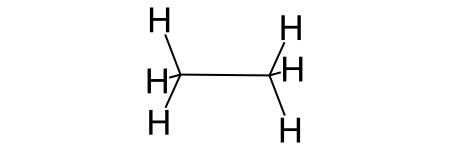


Ethane Non-Aqueous Molecule Structure


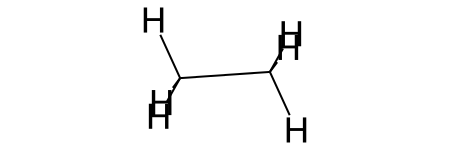

In [ ]:
Ethane_Aqueous_Molecule = Ethane_Properties_dict['Aqueous Molecule']
Ethane_Non_Aqueous_Molecule = Ethane_Properties_dict['Non-Aqueous Molecule']
print("Ethane Aqueous Molecule Structure")
display(Ethane_Aqueous_Molecule)
print()
print("Ethane Non-Aqueous Molecule Structure")
display(Ethane_Non_Aqueous_Molecule)

In [ ]:
paxlovid_string = "CC(C)(C)[C@H](NC(=O)C(F)(F)F)C(=O)N1C[C@H]2[C@@H]([C@H]1C(=O)N[C@H](C#N)C[C@@H]1CCNC1=O)C2(C)C"
paxlovid_properties = Molecule_Properties_Wrapper(paxlovid_string)
paxlovid_properties_dict = paxlovid_properties()
paxlovid_properties_dict

Optimization:   7%|▋         | 7/100 [00:03<00:40,  2.27it/s, Curr_Step=0.15, Energy=-111, Energy_diff=6.75e-5]


{'SMILES': '[H]N1C(=O)[C@]([H])(C([H])([H])[C@@]([H])(C#N)N([H])C(=O)[C@@]2([H])N(C(=O)[C@@]([H])(N([H])C(=O)C(F)(F)F)C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])[C@]3([H])C(C([H])([H])[H])(C([H])([H])[H])[C@@]32[H])C([H])([H])C1([H])[H]',
 'Elements': array(['C', 'C', 'C', 'C', 'C', 'N', 'C', 'O', 'C', 'F', 'F', 'F', 'C',
        'O', 'N', 'C', 'C', 'C', 'C', 'C', 'O', 'N', 'C', 'C', 'N', 'C',
        'C', 'C', 'C', 'N', 'C', 'O', 'C', 'C', 'C', 'H', 'H', 'H', 'H',
        'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H',
        'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H',
        'H', 'H'], dtype='<U1'),
 'Aqueous Molecule XYZ Coords (Angstrom)': array([[-2.81624269e+00,  1.23702461e+00, -3.81810711e+00],
        [-1.81432431e+00,  1.41193716e+00, -2.66040765e+00],
        [-4.50862483e-01,  1.74619687e+00, -3.28338055e+00],
        [-2.27952687e+00,  2.59479492e+00, -1.80493409e+00],
        [-1.71623752e+00,  4.36370447e-02, -1.877

Paxlovid Aqueous Molecule Structure


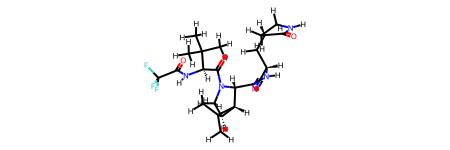


Paxlovid Non-Aqueous Molecule Structure


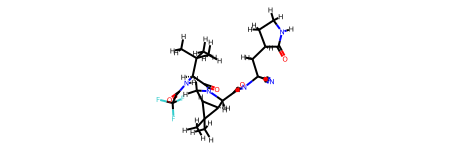

In [ ]:
paxlovid_aqueous_molecule = paxlovid_properties_dict['Aqueous Molecule']
paxlovid_non_aqueous_molecule = paxlovid_properties_dict['Non-Aqueous Molecule']
print("Paxlovid Aqueous Molecule Structure")
display(paxlovid_aqueous_molecule)
print()
print("Paxlovid Non-Aqueous Molecule Structure")
display(paxlovid_non_aqueous_molecule)

In [ ]:
def randomize_molecule(molecule, num_samples=10):
  #This function starts with a dictionary providing possible replacements for every
  #Atom type. The replacement atom types myst have the same number of valence electrons
  #And have had their refrence energies calculated. Following this the amount of each
  #Changable atom is computed, and a random number of each changable atom is changed for each random
  #Molecule. Additionally the atom that it is changed to is also random.
  element_replacement_dict = {
      'H': ['H'],
      'C': ['C'],
      'N': ((['N'] * 3) + ['P']),
      'O': ((['O'] * 3) + ['S']),
      'F': ((['F'] * 3) + ['Cl'])
      }
  molecule_atom_symbol_list = [atom.GetSymbol() for atom in molecule.GetAtoms()]
  molecule_atom_symbol_set = list(set(molecule_atom_symbol_list))
  molecule_atom_type_count_dict = {atom_symbol: molecule_atom_symbol_list.count(atom_symbol) for atom_symbol in molecule_atom_symbol_set}
  num_changable_atoms = molecule_atom_type_count_dict['N'] + molecule_atom_type_count_dict['O'] + molecule_atom_type_count_dict['F']
  num_N_to_change = np.random.randint(0, molecule_atom_type_count_dict['N'], size=num_samples)
  num_O_to_change = np.random.randint(0, molecule_atom_type_count_dict['O'], size=num_samples)
  num_F_to_change = np.random.randint(0, molecule_atom_type_count_dict['F'], size=num_samples)
  num_atoms = molecule.GetNumAtoms()
  changable_atom_index_dict = {
      'N': [],
      'O': [],
      'F': []
  }
  for i in range(num_atoms):
    curr_atom = molecule.GetAtomWithIdx(i)
    curr_atom_symbol = curr_atom.GetSymbol()
    if curr_atom_symbol in ['N', 'O', 'F']:
      changable_atom_index_dict[curr_atom_symbol].append(i)
  random_N_indexes_to_change = []
  random_O_indexes_to_change = []
  random_F_indexes_to_change = []
  random_N_symbols_for_replacement = []
  random_O_symbols_for_replacement = []
  random_F_symbols_for_replacement = []
  for i in range(num_samples):
    curr_num_N_to_change = num_N_to_change[i]
    curr_num_O_to_change = num_O_to_change[i]
    curr_num_F_to_change = num_F_to_change[i]
    random_N_indexes_to_change.append(np.random.choice(changable_atom_index_dict['N'], size=curr_num_N_to_change, replace=False))
    random_O_indexes_to_change.append(np.random.choice(changable_atom_index_dict['O'], size=curr_num_O_to_change, replace=False))
    random_F_indexes_to_change.append(np.random.choice(changable_atom_index_dict['F'], size=curr_num_F_to_change, replace=False))
    random_N_symbols_for_replacement.append(np.random.choice(element_replacement_dict['N'], size=curr_num_N_to_change, replace=True))
    random_O_symbols_for_replacement.append(np.random.choice(element_replacement_dict['O'], size=curr_num_O_to_change, replace=True))
    random_F_symbols_for_replacement.append(np.random.choice(element_replacement_dict['F'], size=curr_num_F_to_change, replace=True))
  mol_list = []
  stereo_isomer_options = Chem.EnumerateStereoisomers.StereoEnumerationOptions(tryEmbedding=True)
  for i in range(num_samples):
    new_molecule = Chem.EditableMol(molecule)
    for j in range(num_N_to_change[i]):
      new_molecule.ReplaceAtom(int(random_N_indexes_to_change[i][j]), Chem.Atom(random_N_symbols_for_replacement[i][j]))
    for k in range(num_O_to_change[i]):
      new_molecule.ReplaceAtom(int(random_O_indexes_to_change[i][k]), Chem.Atom(random_O_symbols_for_replacement[i][k]))
    for l in range(num_F_to_change[i]):
      new_molecule.ReplaceAtom(int(random_F_indexes_to_change[i][l]), Chem.Atom(random_F_symbols_for_replacement[i][l]))
    new_molecule = new_molecule.GetMol()
    isomers = Chem.EnumerateStereoisomers.EnumerateStereoisomers(new_molecule, options=stereo_isomer_options)
    isomers = [Chem.MolToSmiles(isomer) for isomer in isomers]
    mol_list.extend(isomers)
  return mol_list

def compute_similar_drug(molecule, num_samples=10):
  #This function calculates a lot of SMILES similar to the original using randomize molecule
  #Then all of this smiles have their properties calculated and are returned
  #Based on QED score and Hydration energy two important factors in estimating
  #Drug effectivness
  mol_list = randomize_molecule(molecule, num_samples)
  mol_property_calculator_list = [Molecule_Properties_Wrapper(mol) for mol in mol_list]
  mol_property_dict_list = [mol_property_calculator() for mol_property_calculator in mol_property_calculator_list]
  sorted_mol_property_dict_list = sorted(mol_property_dict_list, key=lambda x: (-x['QED Score'], x['Hydration Energy (Kcal/mol)']))
  return sorted_mol_property_dict_list

Optimization:   7%|▋         | 7/100 [00:03<00:44,  2.10it/s, Curr_Step=0.15, Energy=-109, Energy_diff=1.8e-5]


Similar Drug 1


{'SMILES': '[H]N1C(=O)[C@]([H])(C([H])([H])[C@@]([H])(C#N)N([H])C(=O)[C@@]2([H])N(C(=O)[C@@]([H])(N([H])C(=O)C(F)(F)F)C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])[C@]3([H])C(C([H])([H])[H])(C([H])([H])[H])[C@@]32[H])C([H])([H])C1([H])[H]',
 'Elements': array(['N', 'C', 'O', 'C', 'C', 'C', 'C', 'N', 'N', 'C', 'O', 'C', 'N',
        'C', 'O', 'C', 'N', 'C', 'O', 'C', 'F', 'F', 'F', 'C', 'C', 'C',
        'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H',
        'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H',
        'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H',
        'H', 'H'], dtype='<U1'),
 'Aqueous Molecule XYZ Coords (Angstrom)': array([[ 5.95565229e+00,  1.49668214e+00, -1.17950990e+00],
        [ 4.90083618e+00,  1.38242793e+00, -1.93809232e+00],
        [ 4.16543851e+00,  2.37608922e+00, -2.35852546e+00],
        [ 4.62640789e+00, -6.24010261e-02, -2.27533115e+00],
        [ 3.44200259e+00, -6.02810892e-01, -1.456

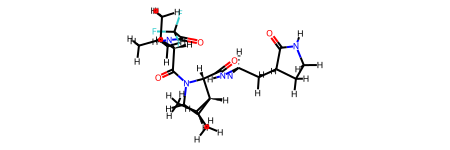


Similar Drug 2


{'SMILES': '[H]N1C(=O)[C@]([H])(C([H])([H])[C@@]([H])(C#N)N([H])C(=O)[C@@]2([H])N(C(=S)[C@@]([H])(N([H])C(=O)C(F)(F)F)C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])[C@]3([H])C(C([H])([H])[H])(C([H])([H])[H])[C@@]32[H])C([H])([H])C1([H])[H]',
 'Elements': array(['N', 'C', 'O', 'C', 'C', 'C', 'C', 'N', 'N', 'C', 'O', 'C', 'N',
        'C', 'S', 'C', 'N', 'C', 'O', 'C', 'F', 'F', 'F', 'C', 'C', 'C',
        'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H',
        'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H',
        'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H',
        'H', 'H'], dtype='<U1'),
 'Aqueous Molecule XYZ Coords (Angstrom)': array([[ 3.34102354,  3.68999816,  1.68258592],
        [ 3.31656178,  2.4302722 ,  1.35889587],
        [ 2.82451296,  1.48390152,  2.08507151],
        [ 3.98358398,  2.21713301,  0.02455794],
        [ 4.79182333,  0.9219586 , -0.07108806],
        [ 3.9632533 , -0.30281317, -0.50821439],

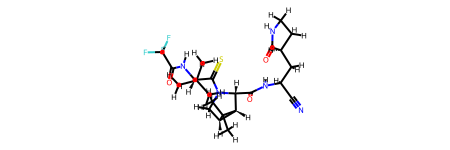


Similar Drug 3


{'SMILES': '[H]N1C(=S)[C@]([H])(C([H])([H])[C@@]([H])(C#N)N([H])C(=O)[C@@]2([H])N(C(=O)[C@@]([H])(N([H])C(=O)C(F)(F)F)C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])[C@]3([H])C(C([H])([H])[H])(C([H])([H])[H])[C@@]32[H])C([H])([H])C1([H])[H]',
 'Elements': array(['N', 'C', 'S', 'C', 'C', 'C', 'C', 'N', 'N', 'C', 'O', 'C', 'N',
        'C', 'O', 'C', 'N', 'C', 'O', 'C', 'F', 'F', 'F', 'C', 'C', 'C',
        'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H',
        'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H',
        'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H',
        'H', 'H'], dtype='<U1'),
 'Aqueous Molecule XYZ Coords (Angstrom)': array([[ 6.17560346,  1.92730489, -0.0267594 ],
        [ 5.29612464,  1.59177046,  0.89264234],
        [ 5.60161568,  0.60011162,  2.18068081],
        [ 3.99513268,  2.32910232,  0.60314414],
        [ 2.685191  ,  1.53808018,  0.71142773],
        [ 2.06828068,  1.38417612,  2.12835887],

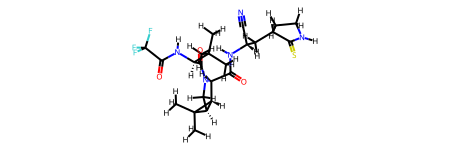


Similar Drug 4


{'SMILES': '[H]N(C(=O)[C@@]1([H])N(C(=S)[C@@]([H])(N([H])C(=O)C(F)(F)F)C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])[C@]2([H])C(C([H])([H])[H])(C([H])([H])[H])[C@@]21[H])[C@]([H])(C#N)C([H])([H])[C@@]1([H])C(=O)P([H])C([H])([H])C1([H])[H]',
 'Elements': array(['N', 'C', 'O', 'C', 'N', 'C', 'S', 'C', 'N', 'C', 'O', 'C', 'F',
        'F', 'F', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C',
        'C', 'N', 'C', 'C', 'C', 'O', 'P', 'C', 'C', 'H', 'H', 'H', 'H',
        'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H',
        'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H',
        'H', 'H'], dtype='<U1'),
 'Aqueous Molecule XYZ Coords (Angstrom)': array([[ 1.50452311,  0.80324738, -0.616989  ],
        [ 1.62424469, -0.15201174, -1.55150406],
        [ 2.54904393, -0.21062123, -2.33249491],
        [ 0.44513521, -1.16849137, -1.63766944],
        [-0.59307102, -1.01545738, -0.61159876],
        [-0.46922089, -1.41859916,  0.67125948],

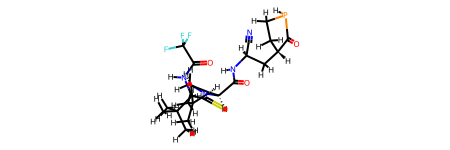

In [ ]:
similar_drug_list = compute_similar_drug(paxlovid_aqueous_molecule, 4)
for i in range(len(similar_drug_list)):
  print(f"Similar Drug {i+1}")
  display(similar_drug_list[i])
  display(similar_drug_list[i]['Aqueous Molecule'])
  print()

In [ ]:
if Env.check != 0:
  Env.show("Error Message")

Env.release_output()